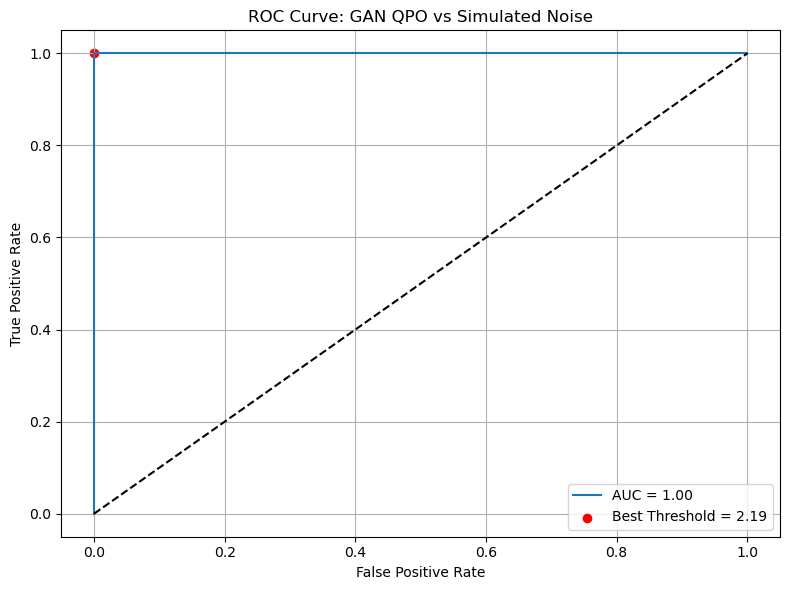

Best Threshold (auto-computed): 2.19
AUC: 1.00


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# --- Load GAN Model ---
generator = tf.keras.models.load_model("saved_models/generator_52.keras")
latent_dim = 100
signal_length = 512

# --- Generate GAN-based QPOs ---
fc_range = (0.01, 0.5)
amp_range = (0.6, 1.0)
qpo_data = []

for _ in range(500):
    z = tf.random.normal((1, latent_dim))
    fc = np.random.uniform(*fc_range)
    amp = np.random.uniform(*amp_range)
    label = tf.convert_to_tensor([[fc, amp]], dtype=tf.float32)
    signal = generator([z, label], training=False).numpy().squeeze()[:signal_length]

    Q = np.random.uniform(4, 10)
    fc_std = np.random.uniform(0.05, 0.12)
    amp_mean = amp
    score = np.log1p(Q) + amp_mean - fc_std

    qpo_data.append({"true_qpo": 1, "Q": Q, "fc_std": fc_std, "amp_mean": amp_mean, "score": score})

df_qpo = pd.DataFrame(qpo_data)

# --- Simulate Non-QPOs ---
non_qpo_data = []
for _ in range(500):
    Q = np.random.uniform(0.5, 1.5)
    fc_std = np.random.uniform(0.15, 0.3)
    amp_mean = np.random.uniform(0.05, 0.2)
    score = np.log1p(Q) + amp_mean - fc_std

    non_qpo_data.append({"true_qpo": 0, "Q": Q, "fc_std": fc_std, "amp_mean": amp_mean, "score": score})

df_non_qpo = pd.DataFrame(non_qpo_data)

# --- Combine and Analyze ---
df_combined = pd.concat([df_qpo, df_non_qpo], ignore_index=True)

fpr, tpr, thresholds = roc_curve(df_combined["true_qpo"], df_combined["score"])
roc_auc = auc(fpr, tpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

# --- Apply Best Threshold ---
df_combined["detected"] = df_combined["score"] > best_threshold

# --- Plot ROC Curve ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f"Best Threshold = {best_threshold:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: GAN QPO vs Simulated Noise")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Best Threshold (auto-computed): {best_threshold:.2f}")
print(f"AUC: {roc_auc:.2f}")
